# Training using pytorch - UNDER CONSTRUCTIOn

In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
from pathlib import Path
import importlib as iml
import tifffile as tif

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import fast.core.training as training
from fast.core import erd 
import torch 
from torch import nn
import fast.input_params as inp

In [15]:
image_path = Path('../training/cameraman/images/cameraman_norm.tif')
database_path = Path('../training/cameraman/c_2/training_database.pkl')

In [9]:
base_path = Path('cameraman')
base_path.mkdir(exist_ok=True)

### Load the cameraman image. 

This image has been normalized so that it has values between 0 and 100.

In [10]:
cameraman = tif.imread(image_path)

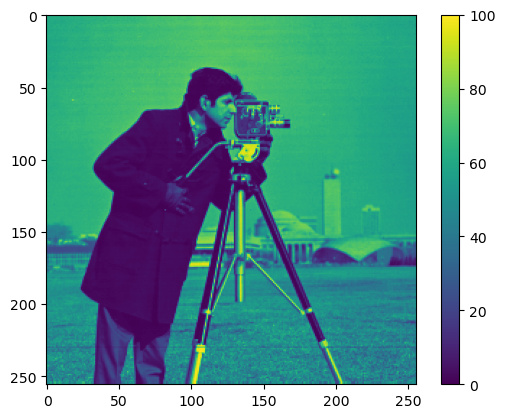

In [11]:
plt.imshow(cameraman)
plt.colorbar()

In [16]:
train_params = inp.TrainingInputParams(
    #input_images_path=base_path / 'images',
    #                               output_dir=base_path, 
                                   num_repeats_per_mask=1,
                                   measurements_per_initial_mask=10,
                                   test_c_values=[2])

In [18]:
features_all, erds_all = training.get_features_and_erds_from_db(database_path)

In [19]:
train_feat, train_erds, val_feat, val_erds = training.training_validation_split(features_all, erds_all, training_split=0.8,random_seed=111)

In [20]:
import torch.nn as nn

In [507]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(50, 50),
            nn.LeakyReLU(),
            nn.Linear(50, 50),
            nn.LeakyReLU(),
            nn.Linear(50, 50),
            nn.LeakyReLU(),
            nn.Linear(50, 50),
            nn.LeakyReLU(),
            nn.Linear(50, 1),
            nn.LeakyReLU()
        )

    def forward(self, x):
        erds = self.linear_relu_stack(x)
        return erds

In [543]:
torch.backends.types()

TypeError: 'module' object is not callable

In [539]:
torch.mps.is_available()

AttributeError: module 'torch' has no attribute 'mps'

In [508]:
model = torch.compile(NeuralNetwork().to('mps'))

In [509]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
OptimizedModule                          --
├─NeuralNetwork: 1-1                     --
│    └─Sequential: 2-1                   --
│    │    └─Linear: 3-1                  2,550
│    │    └─LeakyReLU: 3-2               --
│    │    └─Linear: 3-3                  2,550
│    │    └─LeakyReLU: 3-4               --
│    │    └─Linear: 3-5                  2,550
│    │    └─LeakyReLU: 3-6               --
│    │    └─Linear: 3-7                  2,550
│    │    └─LeakyReLU: 3-8               --
│    │    └─Linear: 3-9                  51
│    │    └─LeakyReLU: 3-10              --
Total params: 10,251
Trainable params: 10,251
Non-trainable params: 0

In [510]:
learning_rate = 1e-3
batch_size = 2**11
epochs = 100

In [511]:
loss_fn = torch.nn.MSELoss(reduction='sum')

In [512]:
with torch.device('mps'):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-4, max_lr=1e-2, mode='triangular2', cycle_momentum=False)

In [513]:
with torch.device('mps'):
    train_x, train_y = torch.tensor(train_feat, dtype=torch.float32), torch.tensor(train_erds[:,None], dtype=torch.float32)
    val_x, val_y = torch.tensor(val_feat, dtype=torch.float32), torch.tensor(val_erds[:,None], dtype=torch.float32)

In [514]:
losses_all = []
val_losses_all = []

In [515]:
def train_loop(model, loss_fn, optimizer):
    #size = len(dataloader.dataset)
    loss_per_epoch = 0
    
    indices_this_epoch = torch.randperm(train_x.shape[0], device='mps')
    batches = train_x.shape[0] // batch_size
    #for batch, indices in enumerate(dataloader):#($X, y) in enumerate(dataloader):
    
    # Compute prediction and loss
    
    #batch_size = indices.shape[0]
    for batch in torch.arange(batches):
        n0 = batch * batch_size
        n1 = (batch + 1) * batch_size
        indices = indices_this_epoch[n0:n1]
        X = train_x[indices]
        y = train_y[indices]
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        loss_per_epoch += loss.item()

        if batch % 10 == 0:
            print(f"loss: {loss.item() / batch_size:>7f}")
    losses_all.append(loss_per_epoch / train_x.shape[0])


def test_loop(model, loss_fn):
    #size = len(dataloader.dataset)
    
    test_loss = 0

    with torch.no_grad():
        indices_this_epoch = torch.randperm(val_x.shape[0], device='mps')
        batches = val_x.shape[0] // batch_size
        #for batch, indices in enumerate(dataloader):#($X, y) in enumerate(dataloader):

        # Compute prediction and loss

        #batch_size = indices.shape[0]
        for batch in torch.arange(batches):
            n0 = batch * batch_size
            n1 = (batch + 1) * batch_size
            indices = indices_this_epoch[n0:n1]
            X = val_x[indices]
            y = val_y[indices]
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    val_losses_all.append(test_loss / val_x.shape[0])

    #test_loss = size
    print(f"Test Error: Avg loss: {val_losses_all[-1]:>8f} \n")

In [516]:
train_data = torch.utils.data.TensorDataset(torch.tensor(train_feat, dtype=torch.float32).to('mps'),
                                            torch.tensor(train_erds[:,None], dtype=torch.float32).to('mps'))

In [517]:
val_data = torch.utils.data.TensorDataset(torch.tensor(val_feat, dtype=torch.float32).to('mps'),
                                          torch.tensor(val_erds[:,None], dtype=torch.float32).to('mps'))

In [518]:
#batch_size=train_feat.shape[0]
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [519]:
train_dl = torch.utils.data.DataLoader(torch.arange(train_feat.shape[0]).to('mps'),  batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(torch.arange(val_feat.shape[0]).to('mps'),  batch_size=batch_size, shuffle=True)

In [520]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop( model, loss_fn, optimizer)
    test_loop( model, loss_fn)
print("Done!")

[2023-04-03 23:46:34,770] torch._dynamo.convert_frame: [ERROR] WON'T CONVERT forward /var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_39195/4250448221.py line 17 
due to: 
Traceback (most recent call last):
  File "/Users/skandel/.conda/envs/slads/lib/python3.10/site-packages/torch/cuda/__init__.py", line 239, in _lazy_init
    raise AssertionError("Torch not compiled with CUDA enabled")
AssertionError: Torch not compiled with CUDA enabled

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/skandel/.conda/envs/slads/lib/python3.10/site-packages/torch/_dynamo/output_graph.py", line 675, in call_user_compiler
    raise BackendCompilerFailed(self.compiler_fn, e) from e
torch._dynamo.exc.BackendCompilerFailed: debug_wrapper raised AssertionError: Torch not compiled with CUDA enabled

Set torch._dynamo.config.verbose=True for more information




Epoch 1
-------------------------------
loss: 5730.519043
loss: 3247.455078
loss: 4402.000000
loss: 3813.088623
loss: 5702.030762
loss: 8672.126953
loss: 4318.460449
loss: 3154.609375
loss: 3958.031738
loss: 5382.211914
loss: 4566.397949
loss: 5524.078125
loss: 4660.333496
loss: 4297.464844
loss: 4047.509033
loss: 4291.114258
loss: 5387.274902
loss: 5047.861328
loss: 3857.320312
loss: 6007.728516
loss: 4307.346680
loss: 2992.432129
loss: 2943.681885
loss: 2405.973145
loss: 4031.386475
loss: 3109.130371
loss: 4027.368652
loss: 1641.841309
loss: 3661.666748
loss: 1727.895020
loss: 3309.604736
Test Error: Avg loss: 2144.021462 

Epoch 2
-------------------------------
loss: 3215.016113
loss: 2359.252930
loss: 1413.805786
loss: 1743.423828
loss: 1956.346436
loss: 1976.089722
loss: 1083.496704
loss: 1711.504517
loss: 1061.064941
loss: 680.055847
loss: 1363.666016
loss: 1764.460205
loss: 1985.097046
loss: 1723.261719
loss: 3344.937012
loss: 1088.137451
loss: 872.679077
loss: 631.510925
loss:

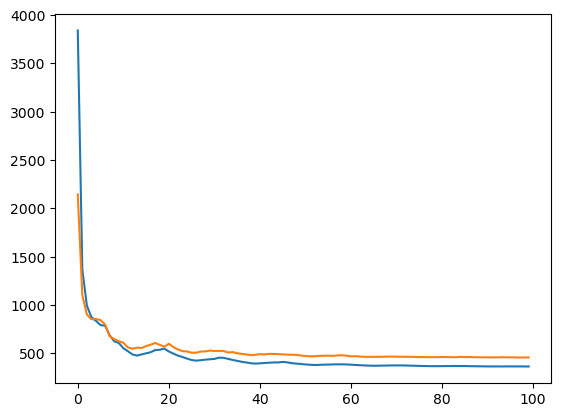

In [521]:
plt.plot(losses_all)
plt.plot(val_losses_all)

In [527]:
torch.save(model.to('cpu').state_dict(), base_path / 'leaky_relu_model.pkl')

In [36]:
input_x = torch.tensor(train_feat).to('mps')

In [37]:
input_y = torch.tensor(val_feat).to('mps')

In [38]:
t1 = modelc(input_x)

In [43]:
optim = torch.optim.Adam(modelc.parameters())

In [32]:
modelc(train_feat[0])

TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [26]:
train_feat[0].shape

(50,)

In [17]:
output_path = base_path

In [528]:
torch.backends.mps.is_built()

True

In [529]:
torch.backends.cuda.is_built()

False

In [531]:
torch.amp.autocast('mps')

RuntimeError: User specified autocast device_type must be 'cuda' or 'cpu'

In [10]:
val_scores = {}
for c_value in tqdm(train_params.test_c_values):

    print('test c', c_value)

    features_erds_db_path = output_path / Path(f'c_{c_value}') / 'training_database.pkl'

    val_scores[c_value] = []

    save_path = features_erds_db_path.parent / f'erd_model_relu.pkl'
    
    features_all, erds_all = training.get_features_and_erds_from_db(features_erds_db_path)
    train_feat, train_erds, val_feat, val_erds = training.training_validation_split(features_all, erds_all, training_split=0.8,random_seed=111)
    
    erd_model, _ = training.fit_erd_model((train_feat, train_erds),
                                          model_params=inp.SladsModelParams(max_iter=50),
                                          save_path=save_path,
                                          training_split=0.8, 
                                          random_seed = 111)
    score = training.validate_erd_model_r_squared((val_feat, val_erds),
                                                  erd_model_path=save_path,
                                                  random_seed = 111)
    print('R squared score', score)
    val_scores[c_value].append(score)
        
    


  0%|          | 0/6 [00:00<?, ?it/s]

test c 2
Ignoring the features db path and train/val split ratio.Directly loading the training features and erds instead.


/home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Ignoring the features db path and train/val split ratio.Directly loading the features and erds instead.
Validation score is 0.8440233325397588
R squared score 0.8440233325397588
test c 4
Ignoring the features db path and train/val split ratio.Directly loading the training features and erds instead.


/home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Ignoring the features db path and train/val split ratio.Directly loading the features and erds instead.
Validation score is 0.8247810382015816
R squared score 0.8247810382015816
test c 8
Ignoring the features db path and train/val split ratio.Directly loading the training features and erds instead.


/home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Ignoring the features db path and train/val split ratio.Directly loading the features and erds instead.
Validation score is 0.5992871880126911
R squared score 0.5992871880126911
test c 16
Ignoring the features db path and train/val split ratio.Directly loading the training features and erds instead.


/home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Ignoring the features db path and train/val split ratio.Directly loading the features and erds instead.
Validation score is 0.5879056979268746
R squared score 0.5879056979268746
test c 32
Ignoring the features db path and train/val split ratio.Directly loading the training features and erds instead.


/home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Ignoring the features db path and train/val split ratio.Directly loading the features and erds instead.
Validation score is 0.5631204595997794
R squared score 0.5631204595997794
test c 64
Ignoring the features db path and train/val split ratio.Directly loading the training features and erds instead.
Ignoring the features db path and train/val split ratio.Directly loading the features and erds instead.
Validation score is 0.6149207861637275
R squared score 0.6149207861637275


/home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [70]:
val_scores

{2: [0.844463214124102],
 4: [0.8288802619955977],
 8: [0.5999938134094193],
 16: [0.5894459831579671],
 32: [0.5631287795830058],
 64: [0.6165459329192193]}